# 코드설명(임시)

- 키포인트 예제코드
- 앞/끝과정 제외하고 source_embed + crop_frames_list로만 생성자 실행하기
- source embedding 추출하는 코드
- source pca
- GAN 중간값 추출하는 프로토타입 코드 (백업용)
- GAN 중간값 pca하는 코드

In [1]:
import tqdm

def nop(it, *a, **k):
    return it

real_tqdm = tqdm.tqdm
tqdm.tqdm = nop

import pickle
import cv2
import torch
import time
import os
import glob

import numpy as np
np.bool = np.bool_

from utils.inference.faceshifter_run import faceshifter_batch
from utils.inference.image_processing import crop_face, get_final_image, show_images, normalize_and_torch, normalize_and_torch_batch
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement, crop_frames_and_get_transforms, resize_frames
from utils.inference.core import model_inference, transform_target_to_torch

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm


/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/numpy/fallback.py:143: DeprecationWarning: In accordance with NEP 32, the function mirr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  mirr = onp.mirr
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/numpy/fallback.py:160: DeprecationWarning: In accordance with NEP 32, the function npv was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  npv = onp.npv
/compuworks/anaconda3/envs/xaise

### Load Models

In [2]:
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[09:21:30] ../src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[09:21:30] ../src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!
[09:21:30] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8204 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


Network [LIPSPADEGenerator] was created. Total number of parameters: 72.2 million. To see the architecture, do print(network).
Load checkpoint from path:  weights/10_net_G.pth


### Set here path to source image and video for faceswap

In [3]:
image_to_image = False

In [4]:
"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
if image_to_image:
    path_to_target = 'examples/images/beckham.jpg'
else:
    #path_to_video = 'examples/videos/random_gif.gif'
    path_to_video = "examples/videos/01__hugging_happy.mp4"
#source_full = cv2.imread('examples/images/elon_musk.jpg')
source_full = cv2.imread('examples/images/Bob-Ross.webp')
OUT_VIDEO_NAME = "examples/results/result_tmp.mp4"
crop_size = 224 # don't change this
BS = 60

[[391.75552 277.68057]
 [457.62897 245.26172]
 [468.77573 315.0874 ]
 [399.43884 374.28156]
 [458.9877  351.1417 ]]
[array([[391.75552, 277.68057],
       [457.62897, 245.26172],
       [468.77573, 315.0874 ],
       [399.43884, 374.28156],
       [458.9877 , 351.1417 ]], dtype=float32)]


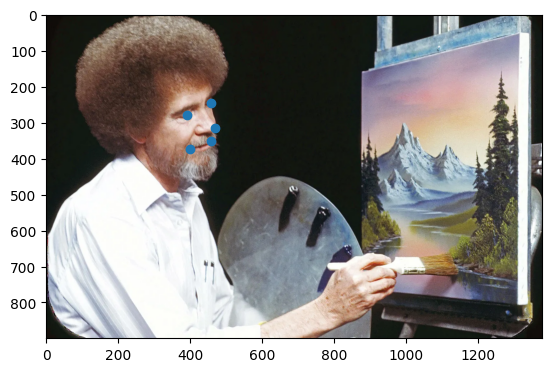

[[ 6.60494333e-01 -6.89314039e-02 -1.45023661e+02]
 [ 6.89314039e-02  6.60494333e-01 -9.97178055e+01]]


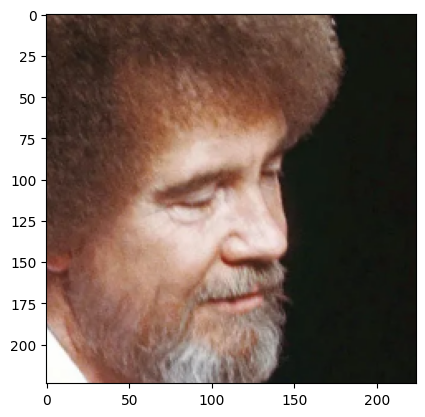

'\ntry:    \n    source = crop_face(source_full, app, crop_size)[0]\n    print(source.shape)\n    source = [source[:, :, ::-1]]\n    print("Everything is ok!")\nexcept TypeError:\n    print("Bad source images")\n'

In [5]:
# check, if we can detect face on the source image
from utils.inference.video_processing import smooth_landmarks

kps = app.get(source_full, crop_size)
print(kps[0])
smooth_kps = smooth_landmarks([kps], n=2)
print(smooth_kps[0])
import matplotlib.pyplot as plt


plt.imshow(source_full[:,:,::-1])
plt.scatter(kps[0][:, 0], kps[0][:, 1])
plt.show()
from insightface.utils import face_align
M, _ = face_align.estimate_norm(kps[0], crop_size, mode ='None') 
print(M)
# M = (2x3) Affine matrix
align_img = cv2.warpAffine(source_full, M, (crop_size,crop_size), borderValue=0.0)

plt.imshow(align_img[:,:,::-1])
plt.show()
source = [align_img]
"""
try:    
    source = crop_face(source_full, app, crop_size)[0]
    print(source.shape)
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")
"""

In [6]:
print(source[0].shape)

print(source_full.shape)

(224, 224, 3)
(900, 1379, 3)


In [7]:
# read video and find target image in the video that contains at least 1 face

if image_to_image:
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

### Model Inference

In [8]:
START_TIME = time.time()

In [9]:
final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=BS)

100%|██████████| 787/787 [00:07<00:00, 110.94it/s]
787it [00:01, 713.10it/s]
787it [00:00, 5180.70it/s]
100%|██████████| 787/787 [00:00<00:00, 1035094.78it/s]


In [ ]:
print(len(final_frames_list))
print(len(final_frames_list[0]))
print(final_frames_list[0][0].shape)

for frame in final_frames_list[0][:100:20]:
    if np.any(frame):
        plt.imshow(frame[:,:,::-1])
        plt.show()

In [11]:
if use_sr:
    final_frames_list = face_enhancement(final_frames_list, model)

40it [00:11,  3.33it/s]


In [ ]:
print(len(final_frames_list))
print(len(final_frames_list[0]))
print(final_frames_list[0][0].shape)

for frame in final_frames_list[0][:100:20]:
    if np.any(frame):
        plt.imshow(frame[:,:,::-1])
        plt.show()

In [13]:
result = get_final_image([final_frames_list[0][:1]], [crop_frames_list[0][:1]], full_frames[0], [tfm_array_list[0][:1]], handler)

/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):
[05:20:40] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):


In [14]:
from utils.inference.masks import face_mask_static
frame = cv2.resize(final_frames_list[0][0], (224, 224))
landmarks = handler.get_without_detection_without_transform(frame)
landmarks_tgt = handler.get_without_detection_without_transform(crop_frames_list[0][0])

mask, _ = face_mask_static(crop_frames_list[0][0], landmarks, landmarks_tgt, None)

/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):


In [ ]:
plt.imshow(frame)
plt.scatter(landmarks[:,0],landmarks[:, 1])
plt.show()


plt.imshow(crop_frames_list[0][0])
plt.scatter(landmarks_tgt[:,0],landmarks_tgt[:, 1])
plt.show()

plt.imshow(mask)
plt.show()

In [ ]:
plt.imshow(result[:, :, ::-1])
plt.show()

In [ ]:
if image_to_image:
    result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
    show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))
else:
    get_final_video(final_frames_list,
                    crop_frames_list,
                    full_frames,
                    tfm_array_list,
                    OUT_VIDEO_NAME,
                    fps, 
                    handler)
    add_audio_from_another_video(path_to_video, OUT_VIDEO_NAME, "audio")

In [18]:
print(f'Full pipeline took {time.time() - START_TIME}')
if not image_to_image:
    print(f"Video saved with path {OUT_VIDEO_NAME}")

Full pipeline took 76.54602766036987
Video saved with path examples/results/result_tmp.mp4


# 특징 빼기 + 인젝션

In [8]:
image_to_image = False
"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
if image_to_image:
    path_to_target = 'examples/images/beckham.jpg'
else:
    #path_to_video = 'examples/videos/random_gif.gif'
    path_to_video = "examples/videos/01__hugging_happy.mp4"
#source_full = cv2.imread('examples/images/elon_musk.jpg')
source_full = cv2.imread('examples/images/Bob-Ross.webp')
OUT_VIDEO_NAME = "examples/results/result_tmp.mp4"
crop_size = 224 # don't change this
BS = 60
# check, if we can detect face on the source image

try:    
    source = crop_face(source_full, app, crop_size)[0]
    print(source.shape)
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")
    
# read video and find target image in the video that contains at least 1 face

if image_to_image:
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

(224, 224, 3)
Everything is ok!


In [13]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

from utils.inference.faceshifter_run import faceshifter_batch
from utils.inference.image_processing import crop_face, normalize_and_torch, normalize_and_torch_batch
from utils.inference.video_processing import read_video, crop_frames_and_get_transforms, resize_frames
from utils.inference.core import transform_target_to_torch

set_target = False
half=True
similarity_th=0.15


target_norm = normalize_and_torch_batch(np.array(target))
target_embeds = netArc(F.interpolate(target_norm, scale_factor=0.5, mode='bilinear', align_corners=True))

# Get the cropped faces from original frames and transformations to get those crops
crop_frames_list, tfm_array_list = crop_frames_and_get_transforms(full_frames, target_embeds, app, netArc, crop_size, set_target, similarity_th=similarity_th)

# Normalize source images and transform to torch and get Arcface embeddings
source_embeds = []
for source_curr in source:
    source_curr = normalize_and_torch(source_curr)
    source_embeds.append(netArc(F.interpolate(source_curr, scale_factor=0.5, mode='bilinear', align_corners=True)))

print(source_embeds[0].shape)

print(crop_frames_list[0][0].shape, crop_frames_list[0][0].dtype)

plt.imshow(crop_frames_list[0][0])
plt.show()

final_frames_list = []
for idx, (crop_frames, tfm_array, source_embed) in enumerate(zip(crop_frames_list, tfm_array_list, source_embeds)):
    # Resize croped frames and get vector which shows on which frames there were faces
    resized_frs, present = resize_frames(crop_frames)
    resized_frs = np.array(resized_frs)

    # transform embeds of Xs and target frames to use by model
    target_batch_rs = transform_target_to_torch(resized_frs, half=half)
    print(target_batch_rs.shape)
    #assert False
    if half:
        source_embed = source_embed.half()

    # run model
    size = target_batch_rs.shape[0]
    model_output = []

    for i in tqdm(range(0, size, BS)):
        Y_st = faceshifter_batch(source_embed, target_batch_rs[i:i+BS], G)
        model_output.append(Y_st)
    torch.cuda.empty_cache()
    model_output = np.concatenate(model_output)

    # create list of final frames with transformed faces
    final_frames = []
    idx_fs = 0

    for pres in tqdm(present):
        if pres == 1:
            final_frames.append(model_output[idx_fs])
            idx_fs += 1
        else:
            final_frames.append([])
    final_frames_list.append(final_frames)
    assert False


[array([[1089.3314 ,  183.92885],
       [1174.1548 ,  206.8646 ],
       [1108.7953 ,  210.90945],
       [1069.2401 ,  267.95343],
       [1135.1351 ,  287.51   ]], dtype=float32), array([[1108.2098 ,  190.56516],
       [1190.8705 ,  216.55504],
       [1128.5043 ,  219.45435],
       [1086.6191 ,  272.8742 ],
       [1152.449  ,  294.73206]], dtype=float32), array([[1123.3899 ,  196.34305],
       [1208.9456 ,  222.89163],
       [1145.9629 ,  227.01839],
       [1104.271  ,  277.7716 ],
       [1172.3827 ,  299.9167 ]], dtype=float32), array([[1140.0278 ,  201.71448],
       [1224.7522 ,  229.60474],
       [1160.8312 ,  235.70796],
       [1119.5988 ,  287.03592],
       [1184.7682 ,  310.86182]], dtype=float32), array([[1156.4579 ,  208.84543],
       [1235.3036 ,  236.57126],
       [1171.6713 ,  239.47604],
       [1133.6367 ,  288.83032],
       [1197.3585 ,  312.3869 ]], dtype=float32), array([[1161.479  ,  216.7366 ],
       [1240.2743 ,  245.95264],
       [1176.5898 ,  24

AssertionError: 

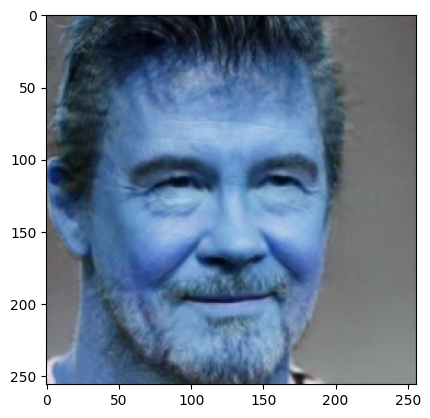

In [131]:
final_frames[0].shape

plt.imshow(Y_st[0])
plt.show()

In [6]:
import time

np.random.seed(7777)

id_folder_list = glob.glob("../vggFace2_Train/*")
id_folder_list.sort()
with open("embed_list.txt", "w") as embed_log:
    output_cnt = 0
    for id_folder in real_tqdm(id_folder_list):
        pics = glob.glob(id_folder+"/*.jpg")
        pics.sort()
        #np.random.shuffle(pics)
        for pic in pics: #pics[:5]:
            source_full = cv2.imread(pic)
            #print(source_full.shape)
            #source = crop_face(source_full, app, crop_size)[0]
            source_curr = cv2.resize(source_full[:, :, ::-1], (crop_size, crop_size))
            source_curr = normalize_and_torch(source_curr)
            #print(source_curr.shape)
            source_embed = netArc(F.interpolate(source_curr, scale_factor=0.5, mode='bilinear', align_corners=True)).cpu().detach().numpy()
            #print(source_embed.shape)
            np.save("./examples/arc_embeds/"+str(output_cnt)+".npy", source_embed[0])
            embed_log.write(pic+"\n")
            #assert False
            output_cnt += 1

#a = glob.glob("../vggFace2_Train/**/*.jpg")
#len(a)

100%|██████████| 8631/8631 [12:07:33<00:00,  5.06s/it]  


In [69]:
a = glob.glob("../vggFace2_Train/**/*.jpg")
len(a)

2565551

In [9]:
from sklearn.decomposition import PCA

embeds_path_list = glob.glob("./examples/arc_embeds/*.npy")
embeds_path_list.sort()

tmp = np.load(embeds_path_list[0])

embed_array = np.zeros([len(embeds_path_list), tmp.shape[0]], dtype=tmp.dtype)

for i, embed_path in enumerate(embeds_path_list):
    embed_array[i] = np.load(embed_path)

pca = PCA(svd_solver="full")

pca.fit(embed_array)


PCA(svd_solver='full')

In [91]:
import pickle
with open("netArcPCA.pkl", "wb") as file:
    pickle.dump(pca, file)


[[-1.45831309 -2.91218561 -2.74709605 ... -0.0109711   0.06906028
  -0.01949976]
 [-1.54323984 -2.88345135 -2.56226107 ...  0.01646118  0.0200644
   0.03217148]
 [-1.50888864 -2.91336455 -2.63369709 ... -0.02764956  0.00526128
   0.00727385]
 ...
 [-1.46263548 -2.88010943 -2.65175549 ... -0.00343136 -0.02023641
  -0.00704339]
 [-1.53983292 -2.88415606 -2.68146959 ...  0.01861276  0.0177595
  -0.03548871]
 [-1.43163991 -2.90456182 -2.58674712 ...  0.00542292 -0.00335126
   0.02753525]]


In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
with open("netArcPCA.pkl", "rb") as file:
    pca = pickle.load(file)

In [10]:
pca_array = pca.transform(embed_array)

pca_minmax = dict({"min": np.amin(pca_array, axis=0), "max": np.amax(pca_array, axis=0)})

with open("netArcPCAMinMax.pkl", "wb") as file:
    pickle.dump(pca_minmax, file)


In [94]:
print(pca_array[0][:10])
print((embed_array[0]-embed_array.mean(axis=0)).dot(pca.components_.T)[:10])
#pca.components_[0][:10]

[ 0.73729     6.45828     1.1065898   1.4121022  -0.36449677 -1.1651448
  0.34845555  2.0992432   0.9984462   0.3670262 ]
[ 0.73729     6.4582796   1.10659     1.4121022  -0.3644966  -1.1651448
  0.34845543  2.0992432   0.99844635  0.36702624]


(224, 224, 3)


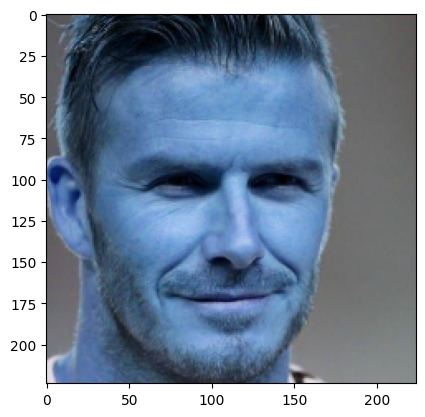

1it [00:00, 3086.32it/s]


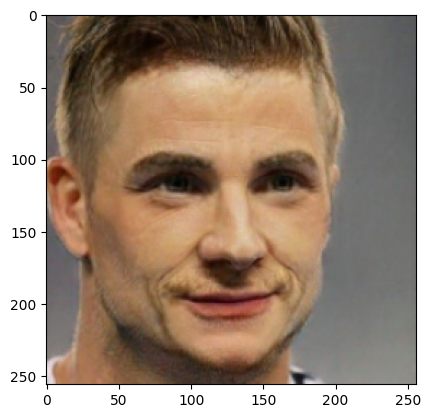

In [146]:
from utils.inference.core import transform_target_to_torch

#frame = cv2.imread("../vggFace2_Train/n000002/0002_01.jpg")

#crop_frames_list = [[cv2.resize(frame, (crop_size, crop_size))]]

print(crop_frames_list[0][0].shape)
plt.imshow(crop_frames_list[0][0])
plt.show()


resized_frs, present = resize_frames(crop_frames_list[0])
resized_frs = np.array(resized_frs)

target_batch_rs = transform_target_to_torch(resized_frs, half=True)


"""
source_full = cv2.imread(pic)
#print(source_full.shape)
#source = crop_face(source_full, app, crop_size)[0]
source_curr = cv2.resize(source_full[:, :, ::-1], (crop_size, crop_size))
source_curr = normalize_and_torch(source_curr)
#print(source_curr.shape)
source_embed = netArc(F.interpolate(source_curr, scale_factor=0.5, mode='bilinear', align_corners=True))
source_embed = source_embed.half()
a
"""
id = 1

modified_embed = pca.inverse_transform(pca_array[id:id+1])

source_embed = torch.from_numpy(modified_embed).half().to("cuda")
#source_embed[0][0] = 10.0

Y_st = faceshifter_batch(source_embed, target_batch_rs, G)
torch.cuda.empty_cache()

plt.imshow(Y_st[0][:, :, ::-1])
plt.show()

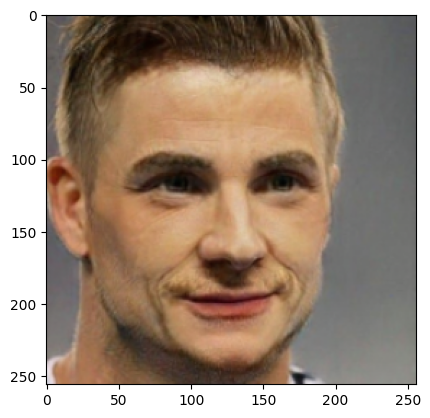

In [142]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

from utils.inference.faceshifter_run import faceshifter_batch
from utils.inference.image_processing import crop_face, normalize_and_torch, normalize_and_torch_batch
from utils.inference.video_processing import read_video, crop_frames_and_get_transforms, resize_frames
from utils.inference.core import transform_target_to_torch

set_target = False
half=True
similarity_th=0.15


target_norm = normalize_and_torch_batch(np.array(target))
target_embeds = netArc(F.interpolate(target_norm, scale_factor=0.5, mode='bilinear', align_corners=True))

# Get the cropped faces from original frames and transformations to get those crops
crop_frames_list, tfm_array_list = crop_frames_and_get_transforms(full_frames, target_embeds, app, netArc, crop_size, set_target, similarity_th=similarity_th)

# Normalize source images and transform to torch and get Arcface embeddings
source_embeds = []
for source_curr in source:
    source_curr = normalize_and_torch(source_curr)
    source_embeds.append(netArc(F.interpolate(source_curr, scale_factor=0.5, mode='bilinear', align_corners=True)))

print(source_embeds[0].shape)

print(crop_frames_list[0][0].shape, crop_frames_list[0][0].dtype)

plt.imshow(crop_frames_list[0][0])
plt.show()

final_frames_list = []
for idx, (crop_frames, tfm_array, source_embed) in enumerate(zip(crop_frames_list, tfm_array_list, source_embeds)):
    # Resize croped frames and get vector which shows on which frames there were faces
    resized_frs, present = resize_frames(crop_frames)
    resized_frs = np.array(resized_frs)

    # transform embeds of Xs and target frames to use by model
    target_batch_rs = transform_target_to_torch(resized_frs, half=half)
    print(target_batch_rs.shape)
    #assert False
    if half:
        source_embed = source_embed.half()

    # run model
    size = target_batch_rs.shape[0]
    model_output = []

    for i in tqdm(range(0, size, BS)):
        Y_st = faceshifter_batch(source_embed, target_batch_rs[i:i+BS], G)
        model_output.append(Y_st)
    torch.cuda.empty_cache()
    model_output = np.concatenate(model_output)

    # create list of final frames with transformed faces
    final_frames = []
    idx_fs = 0

    for pres in tqdm(present):
        if pres == 1:
            final_frames.append(model_output[idx_fs])
            idx_fs += 1
        else:
            final_frames.append([])
    final_frames_list.append(final_frames)
    assert False


# target 중간값 특징 추출
- 쓰면 컴퓨터 멸망함

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

from utils.inference.faceshifter_run import faceshifter_batch
from utils.inference.image_processing import crop_face, normalize_and_torch, normalize_and_torch_batch
from utils.inference.video_processing import read_video, crop_frames_and_get_transforms, resize_frames
from utils.inference.core import transform_target_to_torch


import time
"""
set_target = False
half=True
similarity_th=0.15
crop_size=224
np.random.seed(7777)

id_folder_list = glob.glob("./examples/images/VggFace2-crop/*")
id_folder_list.sort()
with open("VggFace2-cropzattr_embed_list.txt", "w") as embed_log:
    output_cnt = 0
    for id_folder in real_tqdm(id_folder_list):
        pics = glob.glob(id_folder+"/*.jpg")
        pics.sort()
        np.random.shuffle(pics)
        for pic in pics[:2]:
            source_full = cv2.imread(pic)
            full_frames = [source_full]
            #print(source_full.shape)
            #source = crop_face(source_full, app, crop_size)[0]
            source_curr = cv2.resize(source_full[:, :, ::-1], (crop_size, crop_size))
            target = [source_curr.copy()]
            source_curr = normalize_and_torch(source_curr)
            #print(source_curr.shape)
            source_embed = netArc(F.interpolate(source_curr, scale_factor=0.5, mode='bilinear', align_corners=True))


            #get_target(full_frames, app, crop_size)
            print(target[0].shape)
            target_norm = normalize_and_torch_batch(np.array(target))

            target_embeds = netArc(F.interpolate(target_norm, scale_factor=0.5, mode='bilinear', align_corners=True))

            # Get the cropped faces from original frames and transformations to get those crops
            #crop_frames_list, tfm_array_list = crop_frames_and_get_transforms(full_frames, target_embeds, app, netArc, crop_size, set_target, similarity_th=similarity_th)
            #crop_frames = crop_frames_list[0]

            crop_frames = target
            resized_frs, present = resize_frames(crop_frames)
            resized_frs = np.array(resized_frs)


            target_batch_rs = transform_target_to_torch(resized_frs, half=half)
            #assert False
            if half:
                source_embed = source_embed.half()
            
            bs = target_batch_rs.shape[0]
            source_emb = torch.cat([source_embed]*bs)
            
            print(source_emb.shape)
            #Y_st = faceshifter_batch(source_embed, target_batch_rs, G)
            Y_st, zattrs = G(target_batch_rs, source_emb)
            zattrs = list(zattrs)
            for i in range(len(zattrs)):
                zattrs[i] = zattrs[i].detach().cpu().numpy()
            #print(source_embed.shape)

            with open("./examples/z_embeds/VggFace2-crop/"+str(output_cnt)+".pkl", "wb") as file:
                pickle.dump(zattrs, file)
            embed_log.write(pic+"\n")
            #assert False
            output_cnt += 1
"""

(224, 224, 3)
torch.Size([1, 512])


AssertionError: 

# PCA하기 전 데이터 불러오기

# PCA for zattr[0]

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle

emb_array = []

emb_file_list = glob.glob("./examples/z_embeds/VggFace2-crop/*.pkl")

for file_path in emb_file_list:
    with open(file_path, "rb") as file:
        emb_array.append(pickle.load(file)[0].reshape([-1]))
emb_array = np.array(emb_array)


pca = PCA(svd_solver="full")
pca.fit(emb_array)
with open("zattrPCA.pkl", "wb") as file:
    pickle.dump(pca, file)

pca_array = pca.transform(emb_array)

pca_minmax = dict({"min": np.amin(pca_array, axis=0), "max": np.amax(pca_array, axis=0)})

with open("zattrPCAMinMax.pkl", "wb") as file:
    pickle.dump(pca_minmax, file)

In [2]:
import glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
import numpy as np


for attr_id in [1, 2, 3]:
    emb_array = []

    emb_file_list = glob.glob("./examples/z_embeds/VggFace2-crop/*.pkl")

    for file_path in emb_file_list:
            with open(file_path, "rb") as file:
                emb_array.append(pickle.load(file)[attr_id].reshape([-1]))
    emb_array = np.array(emb_array)

    pca = PCA(n_components=1024, svd_solver="auto")

    pca.fit(emb_array)
    print(np.sum(pca.explained_variance_ratio_))
    with open(f"zattr{attr_id}PCA.pkl", "wb") as file:
        pickle.dump(pca, file)

    max_emb = []
    min_emb = []

    for i in range(emb_array.shape[0]):
        tmp = emb_array[i:i+1]
        pca_array = pca.transform(tmp)
        if len(max_emb) == 0:
            max_emb = pca_array
        else:
            max_emb = np.maximum(max_emb, pca_array)
        if len(min_emb) == 0:
            min_emb = pca_array
        else:
            min_emb = np.minimum(min_emb, pca_array)

    pca_minmax = dict({"min": min_emb[0], "max": max_emb[0]})

    with open(f"zattr{attr_id}PCAMinMax.pkl", "wb") as file:
        pickle.dump(pca_minmax, file)
    
    del pca, emb_array, pca_array, max_emb, min_emb, pca_minmax, tmp

0.9977929721355753
0.9799507086672928
0.8972457271133294


# PCA for zattr[4]

In [12]:
import glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
import numpy as np

attr_id = 4


emb_array = []

emb_file_list = glob.glob("./examples/z_embeds/VggFace2-crop/*.pkl")

for file_path in emb_file_list:
    with open(file_path, "rb") as file:
        emb_array.append(pickle.load(file)[attr_id].reshape([-1]))
emb_array = np.array(emb_array)

pca = PCA(n_components=1024, svd_solver="auto")

pca.fit(emb_array)
print(np.sum(pca.explained_variance_ratio_))
with open(f"zattr{attr_id}PCA.pkl", "wb") as file:
    pickle.dump(pca, file)

pca_array = pca.transform(emb_array)

pca_minmax = dict({"min": np.amin(pca_array, axis=0), "max": np.amax(pca_array, axis=0)})

with open(f"zattr{attr_id}PCAMinMax.pkl", "wb") as file:
    pickle.dump(pca_minmax, file)

0.8571562172060723


# PCA for zattr[5~6]

In [1]:
import glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
import numpy as np


for attr_id in [5, 6]:
    emb_array = []

    emb_file_list = glob.glob("./examples/z_embeds/VggFace2-crop/*.pkl")

    for file_path in emb_file_list:
        if np.random.random() < 0.8:
            with open(file_path, "rb") as file:
                emb_array.append(pickle.load(file)[attr_id].reshape([-1]))
    emb_array = np.array(emb_array)

    pca = PCA(n_components=1024, svd_solver="auto")

    pca.fit(emb_array)
    print(np.sum(pca.explained_variance_ratio_))
    with open(f"zattr{attr_id}PCA.pkl", "wb") as file:
        pickle.dump(pca, file)

    max_emb = []
    min_emb = []

    for i in range(emb_array.shape[0]):
        tmp = emb_array[i:i+1]
        pca_array = pca.transform(tmp)
        if len(max_emb) == 0:
            max_emb = pca_array
        else:
            max_emb = np.maximum(max_emb, pca_array)
        if len(min_emb) == 0:
            min_emb = pca_array
        else:
            min_emb = np.minimum(min_emb, pca_array)

    pca_minmax = dict({"min": min_emb[0], "max": max_emb[0]})

    with open(f"zattr{attr_id}PCAMinMax.pkl", "wb") as file:
        pickle.dump(pca_minmax, file)
    
    del pca, emb_array, pca_array, max_emb, min_emb, pca_minmax, tmp

0.8293578069785364
0.8965594179673989


# PCA for zattr[7]

In [1]:
import glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
import numpy as np

attr_id = 7


emb_array = []

emb_file_list = glob.glob("./examples/z_embeds/VggFace2-crop/*.pkl")

for file_path in emb_file_list[::2]:
    with open(file_path, "rb") as file:
        emb_array.append(pickle.load(file)[attr_id].reshape([-1]))
emb_array = np.array(emb_array)

pca = PCA(n_components=512, svd_solver="auto")

pca.fit(emb_array)
print(np.sum(pca.explained_variance_ratio_))
with open(f"zattr{attr_id}PCA.pkl", "wb") as file:
    pickle.dump(pca, file)



max_emb = []
min_emb = []

for i in range(emb_array.shape[0]):
    tmp = emb_array[i:i+1]
    pca_array = pca.transform(tmp)
    if len(max_emb) == 0:
        max_emb = pca_array
    else:
        max_emb = np.maximum(max_emb, pca_array)
    if len(min_emb) == 0:
        min_emb = pca_array
    else:
        min_emb = np.minimum(min_emb, pca_array)

pca_minmax = dict({"min": min_emb[0], "max": max_emb[0]})

with open(f"zattr{attr_id}PCAMinMax.pkl", "wb") as file:
    pickle.dump(pca_minmax, file)

0.8869378560189847


: 

In [3]:
import tqdm

def nop(it, *a, **k):
    return it

real_tqdm = tqdm.tqdm
tqdm.tqdm = nop

import glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
import numpy as np

attr_id = 7

with open(f"zattr{attr_id}PCA.pkl", "rb") as file:
    pca = pickle.load(file)



emb_file_list = glob.glob("./examples/z_embeds/VggFace2-crop/*.pkl")

max_emb = []
min_emb = []

for file_path in real_tqdm(emb_file_list):
    with open(file_path, "rb") as file:
        tmp = pickle.load(file)[attr_id].reshape([1,-1])
    
    pca_array = pca.transform(tmp)
    if len(max_emb) == 0:
        max_emb = pca_array
    else:
        max_emb = np.maximum(max_emb, pca_array)
    if len(min_emb) == 0:
        min_emb = pca_array
    else:
        min_emb = np.minimum(min_emb, pca_array)

pca_minmax = dict({"min": min_emb[0], "max": max_emb[0]})

with open(f"zattr{attr_id}PCAMinMax.pkl", "wb") as file:
    pickle.dump(pca_minmax, file)


In [8]:
pca.components

AttributeError: 'PCA' object has no attribute 'components'